## plausibiliteit op basis vanuit neerslag gevens in bui-bestanden en waterstanden en afvoeren in opgeslagen in his-bestanden

Deze notebook bevat informatie hoe het mogelijk is om .his- en .bui-bestanden uit te lezen binnen Python en op welke manier hieruit de plausibiliteitsuit af te leiden. Een aantal functies worden hierbij toegelicht. Waarbij elke functie in detail is beschreven in de toebehorende `docstring`.

In [1]:
import hkvsobekpy as hkv
import geopandas as gpd
import os

Ook bepalen we de input bestanden.

In [2]:
bui_file = r'input_data\plausibiliteits-validatie\T100ST2.BUI'
his_folder = r'input_data\plausibiliteits-validatie'
shp_file = r'input_data\plausibiliteits-validatie\Sbk_FGrPt_n.dbf'

Naast het .his-bestand is er een .shp-bestand gedefinieerd met een bijbehorende .dbf-bestand. De kolom met naam van his-file, locatie en parameter die hierin staan gedefinieerd worden gebruikt voor het inlezen van de periode in een his-bestand. 
Het is daarom van belang dat deze namen correct zijn. 

De shp-file kunnen we als volgt inlezen naar een `GeoDataFrame` en vervolgens plotten in figuur (de `shp`) en tabel (de `dbf`)

In [3]:
gdf = gpd.read_file(shp_file)
# gdf.plot() # in geval van een shp bron-bestand
gdf.head()

,ID________,NAME______,TYPE______,PARENTID__,USERID____,X_________,Y_________,Z_________,COLOR_____,HIS_FILE,LOCATIES,PARAMETERS,geometry
0,calc_1,0.000000000000000,Flow - Fixed Calculation Point,SBK_GRIDPOINTFIXED,,80423.3177,454347.0958,0.0,8388863.0,calcpnt,calc_1,Waterlevel mean (m AD,None
1,calc_2,0.000000000000000,Flow - Fixed Calculation Point,SBK_GRIDPOINTFIXED,,80427.9324,454338.2494,0.0,8388863.0,calcpnt,calc_2,Waterlevel mean (m AD,None
2,calc_4,24.699999999999999,Flow - Fixed Calculation Point,SBK_GRIDPOINTFIXED,,81859.9993,456551.2446,0.0,8388863.0,reachseg,1,Waterlevel slope MEA,None
3,calc_6,27.000000000000000,Flow - Fixed Calculation Point,SBK_GRIDPOINTFIXED,,82463.6157,456893.4409,0.0,8388863.0,reachseg,1,Discharge mean (m3/s),None


Te zien is dat de dbf behorende bij de shapefile heeft de kolom `his_file` met daarin de namen van de daarbij behorende his-file. In de `locaties` kolom staan de locaties of interest en in de kolom `parameters` staan de parameter welke van belang is. 

Deze drie koloms worden als shp_key gedefineerd:

In [4]:
shp_hiskey = 'HIS_FILE'
shp_locationkey = 'LOCATIES'
shp_parameterkey = 'PARAMETERS'

Voor demo doeleinden werken we verder met de eigenschappen van deze keys voor regel 2

In [5]:
row = 1
his_file = gdf[shp_hiskey].iloc[row]
location = gdf[shp_locationkey].iloc[row]
parameter = gdf[shp_parameterkey].iloc[row]

# selection of location and parameter through `read_his`
# hkv.read_his.LeesMetadata(os.path.join(his_folder,'{0}.his'.format(his_file)))
# parameter = hkv.read_his.KrijgParameters()[0]
# locatie = hkv.read_his.KrijgLokaties()[40]

print(' his_file : {0}\n location : {1}\n parameter : {2}'.format(his_file, location, parameter))

 his_file : calcpnt
 location : calc_2
 parameter : Waterlevel mean (m AD


Met de volgende commando kunnen we vervolgens een series uitlezen uit dit his-bestand. Als input gebruiken we een zelf gedefineerde parameter vanuit de dbf/shp file. Sinds het matchen van de juiste parameter naam in het his-bestand niet altijd even makkelijk is (superscript-, codec-, hoofdletter-, spatie-, spelfout-gevoelig) zijn er twee extra opties om dit proces te vermakkelijken. 

Namelijk:

1. NFKD unicode compatibiliteit decompositie (`normalize_by_unicode=True`) en 
2. patroonherkenning (`include_simularity=True`)

Voor de patroonherkenning is ook een grenswaarde vereist, deze staat nu op 0.82 (`sequence_simularity`). 

Wanneer de input-parameter niet identiek is, maar wel een match gevonden kan worden via de compatibiliteit decompositie of patroonherkenning kan deze met `return_matching_parameter` geretourneerd worden. Zie onderaan dit notebook voor een voorbeeld van de verschillen.

In [6]:
df_his, parameter = hkv.read_his.read_series(his_file=his_file, location=location, parameter=parameter,                                              
                                             his_folder=his_folder, 
                                             normalize_by_unicode=True, include_simularity=True, sequence_simularity=0.82,
                                             return_matching_parameter=True)
df_his.head()

Waterlevel mean (m AD changed into Waterlevel mean (m A, since similarity is 0.98


location,calc_2
parameter,Waterlevel mean (m A
1950-01-01 00:00:00,-0.430000
1950-01-01 00:15:00,-0.448960
1950-01-01 00:30:00,-0.529395
1950-01-01 00:45:00,-0.493480
1950-01-01 01:00:00,-0.480057


Informatie in het bui-bestand kunnen we op de volgende manier inlezen.

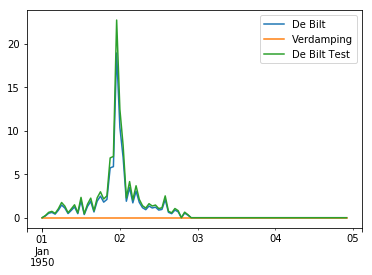

In [7]:
# parse bui-file to pandas dataframe
df_bui = hkv.read_bui(bui_file)

# location to query
bui_location = 'De Bilt'
# since it's hour data, only plot 6 months
df_bui.plot()

In [8]:
df_bui.head()

,De Bilt,Verdamping,De Bilt Test
1950-01-01 00:00:00,0.00000,0,0.000000
1950-01-01 01:00:00,0.20691,0,0.248292
1950-01-01 02:00:00,0.51183,0,0.614196
1950-01-01 03:00:00,0.60984,0,0.731808
1950-01-01 04:00:00,0.41382,0,0.496584


Het resultaat is een DataFrame met in de kolommen de neerslag in mm voor de stations en in de rijen de waarnemingstijdstappen

Om een combinatie plot te maken van bui-bestand en een his-bestand is het allereerst van belang om een aantal eigenschappen in te lezen.

In [9]:
bui_locations = ['De Bilt','Verdamping','De Bilt Test']
df_bui_sel, start_his, end_his, df_bui_std, df_his_std = hkv.plausibility.prepare_bui_his(df_his, df_bui, bui_locations)

In [10]:
out_folder =r'output_data\plausibiliteits-validatie'

Voor de het plotten van de bui-lokaties is het mogelijk om deze als een bar-chart te plotten (tot 3 lokaties). Dit kan met de optie `barthreshold` (kies uit 1, 2 of 3 [waarden boven 3 worden als 3 behandeld]). Sinds het plotten van meerde lokaties als bar-chart lastig is qua visualisatie (ze komen boven op elkaar), kan er met `barwidth` en `baroffset` enigszins getuned worden om een voor de gebruiker juiste plot te krijgen.

Wanneer het aantal input bui-lokaties boven de `barthreshold` uitkomt, wordt het figuur geplot met een lijndiagram met een transparante filling zodat de verschillende buien zichtbaar blijven. 

create a barchart for the bui-locations


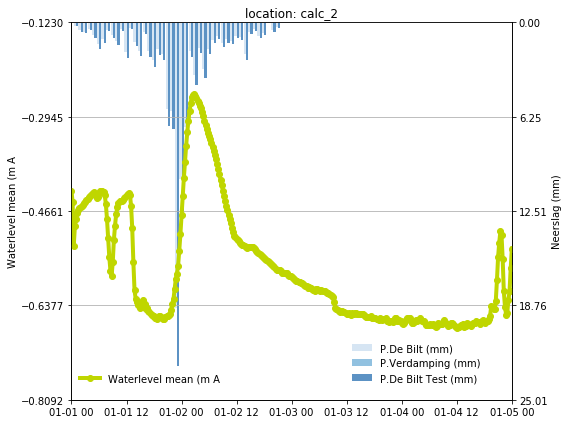

In [11]:
hkv.plausibility.plot_bui_his(df_his, df_bui_sel, start_his, end_his, 
                              df_bui_std, df_his_std, his_file, 
                              parameter, location, out_folder, 
                              savefigure=False, barthreshold=3, barwidth=0.02, baroffset=0.01 )

En in tabel formaat

In [12]:
df_bui_his = hkv.plausibility.table_bui_his(df_his, df_bui_sel)
df_bui_his.head()

location,calc_2,De Bilt,Verdamping,De Bilt Test
parameter,Waterlevel mean (m A,Precipitation (mm),Precipitation (mm),Precipitation (mm)
1950-01-01 00:00:00,-0.430000,0.00000,0.0,0.000000
1950-01-01 00:15:00,-0.448960,NaN,NaN,NaN
1950-01-01 00:30:00,-0.529395,NaN,NaN,NaN
1950-01-01 00:45:00,-0.493480,NaN,NaN,NaN
1950-01-01 01:00:00,-0.480057,0.20691,0.0,0.248292


Deze tabel kan op de volgende manier weggeschreven worden als csv-bestand.
De uitgecommenteerde code laat zien hoe het csv-bestand weer ingelezen kan worden.

In [13]:
bui_his_to_csv = os.path.join(out_folder, 'comb_his_bui.csv')
df_bui_his.to_csv(bui_his_to_csv)

## use pandas to read exported csvfile
# import pandas as pd

# df_in = pd.read_csv(bui_his_to_csv, header=[0, 1])
# df_in.head()

Al het bovenstaande kan ook automatsich weggeschreven worden naar de output folder. Binnen de output folder worden de afgeleide figuren weggeschreven. De opties die hierboven zijn uitgewerkt zijn ook beschikbaar binnen de `EnsembleRunner`.

In [14]:
hkv.plausibility.EnsembleRunner(shp_file, bui_file, his_folder, out_folder, shp_hiskey, shp_locationkey, shp_parameterkey)

start ensemble runner
read shp-file
read bui-file
Waterlevel mean (m AD changed into Waterlevel mean (m A, since similarity is 0.98
create a barchart for the bui-locations
Waterlevel mean (m AD changed into Waterlevel mean (m A, since similarity is 0.98
create a barchart for the bui-locations
Normalized unicode Waterlevel slope MEA matches Waterlevel slope mea
create a barchart for the bui-locations
Discharge mean (m3/s) changed into Discharge mean(m³/s), since similarity is 0.98
create a barchart for the bui-locations

done


#### Verschil qua mapping van `normalize_by_unicode` en `include_simularity` met een voorbeeld:

His-parameter naam : `Discharge mean(m³/s)`

Foutieve inputs vanuit de dbf/shp file:

a. : `Discharge mean (m3/s)`

b. : `DiscHaRge Mean`

c. : `Discharge mean(m3/s)`


Opties:
`normalize_by_unicode=`**`True`**, `include_simularity=`**`False`**

alleen `Discharge mean (m3/s)` (optie `a`) wordt gemapped

  .
  
`normalize_by_unicode=`**`False`**, `include_simularity=`**`True`**

zowel `Discharge mean (m3/s)` (optie `a`) als

`Discharge mean(m3/s)` (optie `c`) wordt gemapped

  .
  
`normalize_by_unicode=`**`True`**, `include_simularity=`**`True`**

zowel `Discharge mean (m3/s)` (optie `a`) als

`DiscHaRge Mean` (optie `b`) en

`Discharge mean(m3/s)` (optie `c`) wordt gemapped.